In [71]:
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [2]:
# count the number of rows in the table
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
q = '''
    SELECT count()
    FROM ldn_listings
    '''

In [4]:
q_count = ph.read_clickhouse(query=q, connection=connection_default)
q_count

,count()
0,85207


In [5]:
# Unload price data from the table depending on the type of housing
q = '''
    SELECT
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
    FROM ldn_listings
    ORDER BY id
    LIMIT 1000
    '''
q_price = ph.read_clickhouse(query=q, connection=connection_default)

In [6]:
# Group the obtained dataframe by type of housing and calculate the 75th percentile of the price
q_price.groupby('room_type', as_index=False).quantile(0.75)

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


In [8]:
# Build a scatter plot that shows the dependence of the average rating on the average price by type of housing
q = '''
    SELECT
    room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
        toFloat32OrNull(review_scores_rating) as review_scores_rating
    FROM ldn_listings
    WHERE
        isNotNull(review_scores_rating)
    ORDER BY id
    LIMIT 1000
    '''

In [9]:
q_for_average = ph.read_clickhouse(query=q, connection=connection_default)
avg_toom_type = q_for_average \
            .groupby('room_type', as_index=False) \
            .agg({'price': 'mean', 'review_scores_rating': 'mean'}) \
            .rename(columns={'price': 'avg_price', 'review_scores_rating': 'avg_review_scores_rating'})

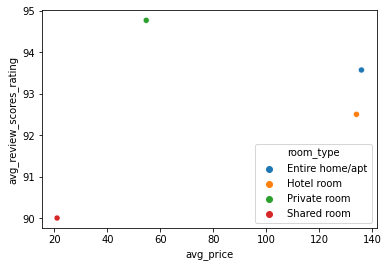

In [10]:
# build scatter
sns.scatterplot(data=avg_toom_type, x="avg_price", y="avg_review_scores_rating", hue="room_type")

In [11]:
# check which account verification methods were used by hosts offering different experiences
q = '''
    SELECT
        DISTINCT host_id,
        host_verifications
    FROM ldn_listings
    WHERE
        experiences_offered != 'none'
    ORDER BY id
    '''

In [24]:
q_verification = ph.read_clickhouse(query=q, connection=connection_default)

In [26]:
q_verification.host_verifications = q_verification.host_verifications \
                .apply(lambda x: x.strip('[]').replace("'", '').split(', '))
q_verification.explode('host_verifications').value_counts('host_verifications')

host_verifications
phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
dtype: int64

In [27]:
# how many ads and in which areas the hosts have indicated impressions?
q = '''
    SELECT
        neighbourhood_cleansed,
        experiences_offered,
        count(experiences_offered) as experiences_count     
    FROM ldn_listings
    WHERE
        experiences_offered != 'none'
    GROUP BY
        neighbourhood_cleansed, experiences_offered
    ORDER BY
        experiences_count DESC
    LIMIT 100
    '''

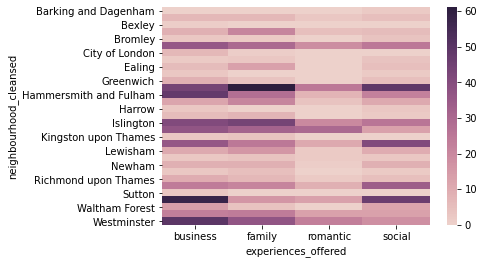

In [37]:
q_ads = ph.read_clickhouse(query=q, connection=connection_default)
ads_pivot = q_ads.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count').fillna(0)
sns.heatmap(ads_pivot,cmap=sns.cubehelix_palette(as_cmap=True))

In [49]:
# Upload price per night data for different types of accommodation that also have an experience available
q = '''
    SELECT
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
    FROM ldn_listings
    WHERE
        experiences_offered != 'none'
    '''

In [50]:
q_accommodation = ph.read_clickhouse(query=q, connection=connection_default)

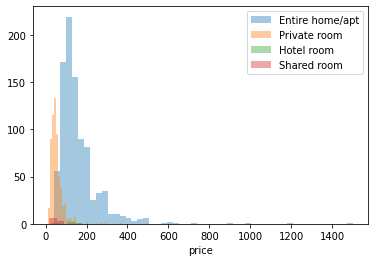

In [77]:
sns.distplot(q_accommodation.loc[q_accommodation.room_type == 'Entire home/apt'].price, kde=False, label='Entire home/apt')
sns.distplot(q_accommodation.loc[q_accommodation.room_type == 'Private room'].price, kde=False, label='Private room')
sns.distplot(q_accommodation.loc[q_accommodation.room_type == 'Hotel room'].price, kde=False, label='Hotel room')
sns.distplot(q_accommodation.loc[q_accommodation.room_type == 'Shared room'].price, kde=False, label='Shared room')
plt.legend()
plt.show()

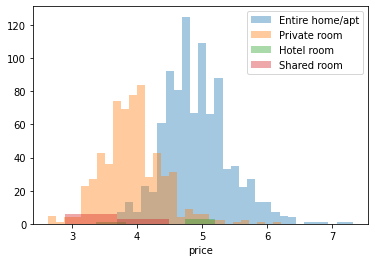

In [78]:
sns.distplot(np.log(q_accommodation.loc[q_accommodation.room_type == 'Entire home/apt'].price), kde=False, label='Entire home/apt')
sns.distplot(np.log(q_accommodation.loc[q_accommodation.room_type == 'Private room'].price), kde=False, label='Private room')
sns.distplot(np.log(q_accommodation.loc[q_accommodation.room_type == 'Hotel room'].price), kde=False, label='Hotel room')
sns.distplot(np.log(q_accommodation.loc[q_accommodation.room_type == 'Shared room'].price), kde=False, label='Shared room')
plt.legend()
plt.show()

In [79]:
# Download and visualize price, property type, and date of first review starting January 2, 2010
q = '''
    SELECT
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
        first_review  
    FROM ldn_listings
    WHERE
        first_review > '2010-01-01'
    LIMIT 1000
    '''

In [80]:
q_avg_prices = ph.read_clickhouse(query=q, connection=connection_default)

In [96]:
avg_price_groups = q_avg_prices \
                .groupby(['first_review_year', 'room_type'], as_index=False) \
                .mean('price') \
                .rename(columns={'price': 'avg_price'}) \
                .sort_values('first_review_year')

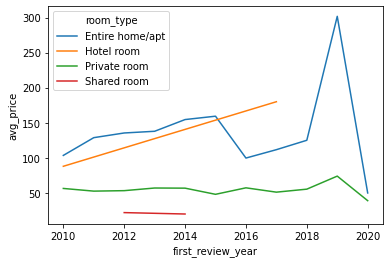

In [97]:
sns.lineplot(data=avg_price_groups, x="first_review_year", y="avg_price", hue="room_type")